In [1]:
import os
os.chdir('../src')

from molecular_cloud_initialization import *
from plotters import *
from cluster_cloud_initialization import *

import numpy as np
import matplotlib.pyplot as plt
from amuse.community.fi.interface import Fi
from amuse.lab import Particles, nbody_system
from amuse.couple import bridge
from amuse.units import units
from amuse.community.bhtree.interface import Bhtree
from amuse.community.sse.interface import SSE
from amuse.ext.stellar_wind import new_stellar_wind
from amuse.ext.sink import new_sink_particles

In [2]:
tot_cloud_mass = 4/3 *units.constants.pi * (15 | units.pc)**3 * ( 2.3 | units.amu * 10 / (units.cm**3))
print(tot_cloud_mass.value_in(units.MSun))

#Assmuing a pure molecular hydrogen cloud, with typical density around 85 molecules per cm^-3, calculate the approximate cloud mass based on
#cloud size. 50 pc is selected for a small GC of only 100 stars. 

7975.78734729


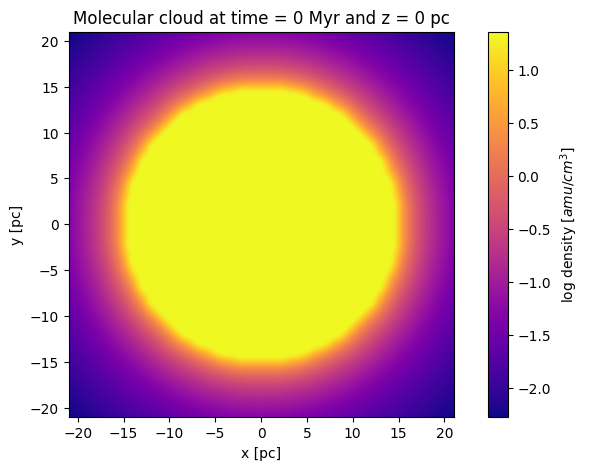

ready for evolution
Time 0.2 Myr
Time 0.4 Myr
Time 0.6 Myr
Time 0.8 Myr
Time 1.0 Myr
Time 1.2 Myr
Time 1.4 Myr
Time 1.6 Myr
Time 1.8 Myr
Time 2.0 Myr


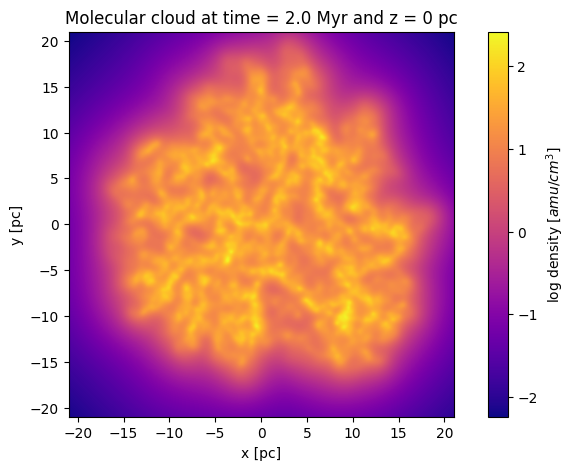

Average mass of a SPH particle 0.05432162475979687.
Mean density of the molecular cloud 6.76090846385e-20 m**-3 * kg


In [3]:
# initialise and evolve the MC particle set
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 150000,
                                                         M_cloud = 8000 | units.MSun,
                                                         R_cloud = 15 | units.pc,
                                                         seed = 1312)

initial_particles_cloud, density_map = evolve_molecular_cloud(particles_cloud, 
                                                    converter_cloud, 
                                                    t_end = 2 | units.Myr, 
                                                    dt = 0.2 | units.Myr, 
                                                    seed = 1312)

print("Mean density of the molecular cloud", np.mean(initial_particles_cloud.density))

In [4]:
particles_cloud = initial_particles_cloud.copy()

cluster generated


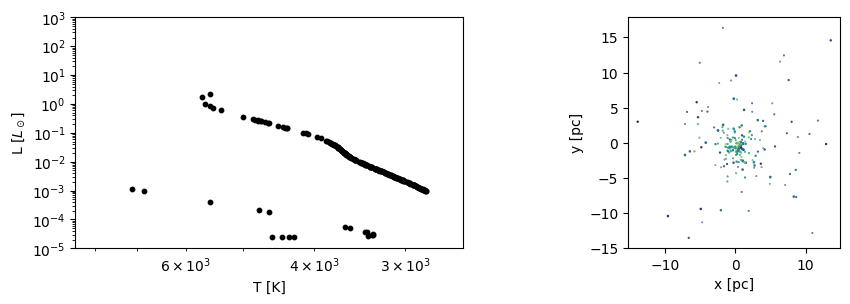

In [5]:
star_cluster = make_globular_cluster(star_count = 200,
                                    imf = "kroupa", 
                                    radius = 4 | units.pc,
                                    metallicity = 0.002, 
                                    age = 10 | units.Gyr, 
                                    seed = 2804)

star_cluster.name = "Unchanged star"

star_cluster.position +=  (-1.0, 0, 0) * (30 | units.pc)
star_cluster.velocity += (1.0, 0, 0) * (20| units.kms)

converter_cluster = nbody_system.nbody_to_si(star_cluster.mass.sum(), 
                                   star_cluster.position.sum())

In [20]:
def hydro_code(Code, dt, converter, particles, seed):
    '''
    This function contains the parameters we want to initialise the 
    hydro code with. (hard Coded)
    '''
    
    np.random.seed(seed)

    hydro = Code(converter)
    hydro.parameters.use_hydro_flag = True # Hydrodynamics flag. True means:
                            # SPH hydro included, False means: gravity only.
    hydro.parameters.gamma = 1 # gas polytropic index (1.6666667)
                        # (default value:1.6666667). In this case-> Ideal Gas   
    hydro.parameters.timestep = dt
    hydro.parameters.eps_is_h_flag = True # Default value
    hydro.parameters.radiation_flag = False # turns off radiatiative cooling/heat.
    hydro.parameters.isothermal_flag = True  # Isothermal flag. True means:
                                            # isothermal gas (requires integrate_entropy_flag == False)
    hydro.parameters.integrate_entropy_flag = False #True means: integrate
                                                     # entropy, else: internal energy. 
    hydro.gas_particles.add_particles(particles) # add the particles
   
    return hydro    

In [21]:
#initiate the gravity code with sink particles
gravity_code = Bhtree(converter_cluster)
sinks = new_sink_particles(star_cluster)

gravity_code.particles.add_particles(sinks)

In [22]:
stellar_evolution_code = SSE()
stellar_evolution_code.parameters.metallicity = sinks[0].metallicity
stellar_evolution_code.particles.add_particles(sinks)

In [23]:
# #start the hydro code for the gas
hydro_cloud = hydro_code(Code = Fi, dt = 0.1 | units.Myr,
                         converter = converter_cloud,
                         particles = particles_cloud,
                         seed = 1312)


channel = {"gravity_to_sinks": gravity_code.particles.new_channel_to(sinks),
            "gravity_from_sinks": sinks.new_channel_to(gravity_code.particles, attributes=["mass", "radius"], target_names=["mass", "radius"]),
            "stellar_evolution_to_sinks": stellar_evolution_code.particles.new_channel_to(sinks),
            "stellar_evolution_from_sinks": sinks.new_channel_to(stellar_evolution_code.particles),
            "stellar_evolution_to_gravity": stellar_evolution_code.particles.new_channel_to(gravity_code.particles),
            "hydro_to_cloud": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
            "hydro_from_cloud": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}

channel["stellar_evolution_to_sinks"].copy()

In [24]:
gravhydrostellarbridge = bridge.Bridge(use_threading = False)
gravhydrostellarbridge.add_system(gravity_code, (hydro_cloud,))
gravhydrostellarbridge.add_system(hydro_cloud, (gravity_code,))
gravhydrostellarbridge.timestep = 0.1 | units.Myr

In [25]:
def bondi_radius(stellar_mass):
    sound_speed = 0.2 | units.kms
    R = 2 * units.constants.G * stellar_mass /(sound_speed **2)
    
    return R

# def bondi_accretion_rate(rho,v,r):
#     dM = units.constants.pi * (r**2) * rho * v

#     return dM

In [26]:
def detect_bounded_gas(star,particles,hardness):

    n = len(particles)

    if n == 0:
        return Particles()
    
    total_Ek = (0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek = total_Ek/particles.mass.sum()
    max_mass = particles.mass.amax()
    limitE = hardness*average_Ek

    a = np.argsort(particles.x.number)
    binaries = Particles()

    for i in range(n):
        r2 = (star.x-particles.x[a[i]])**2+ \
            (star.y-particles.y[a[i]])**2+ \
            (star.z-particles.z[a[i]])**2 
        v2 = (star.vx-particles.vx[a[i]])**2+ \
            (star.vy-particles.vy[a[i]])**2+ \
            (star.vz-particles.vz[a[i]])**2 
        r = r2**0.5
        #Specific binding energy in units energy per mass
        eb = abs(units.constants.G*(particles.mass[a[i]]+star.mass)/r-0.5*v2)
        if eb > limitE:
            binary=particles[[a[i]]].copy()
            binary.hardness=eb/average_Ek
            binaries.add_particle(binary)
    
    return binaries

In [27]:
def free_fall_time(star,particles,binary_particles,time_step):

    n = len(binary_particles)
    dm = []
    
    if n == 0:
        return Particles(), dm
    
    a = np.argsort(binary_particles.x.number)
    binaries = Particles()
    
    bg_rho = particles.mass.sum()/(4/3*np.pi*star.sink_radius**3)
    
    for i in range(n):
        
        distance = np.sqrt((star.x-binary_particles.x[a[i]])**2 + \
                            (star.y-binary_particles.y[a[i]])**2 + \
                            (star.z-binary_particles.z[a[i]])**2)
        
        free_fall_radius = (2*time_step*np.sqrt(2*units.constants.G \
                                            *(star.mass + binary_particles.mass[a[i]]))/np.pi)**(2/3)
        free_fall_radius = free_fall_radius.in_(units.m)
        
    
        binary = binary_particles[[a[i]]].copy()
        binaries.add_particle(binary)

        if free_fall_radius >= distance:
            dm.append(binary.mass.value_in(units.MSun))

        else:
            gas_rho = binary_particles.mass[a[i]]/(4/3*np.pi*distance**3)
            mean_rho = (0.5*bg_rho+1.5*gas_rho)/2
            acquired_mass = mean_rho * 4*np.pi*(free_fall_radius**3)/3 
            acquired_mass = acquired_mass.value_in(units.MSun)
            dm.append(acquired_mass)
    
    dm = dm | units.MSun
    return binaries,dm

In [28]:
def accrete_mass(sinks, hydro_particles,time_step):
    # For each sink, find the hydro particles that are located within the sink radius
    particles_within_sink_radius = sinks.select_too_close(hydro_particles)

    for idx in range(len(sinks)):
        # Select the ones that are gravitationally bound to the sink
        bounded_particles = detect_bounded_gas(sinks[idx], particles_within_sink_radius[idx], hardness = 0.1)
        bounded_particles,dmass = free_fall_time(sinks[idx],particles_within_sink_radius[idx],\
                                               bounded_particles, time_step)
        if len(bounded_particles) != 0:
            # Update the mass of the sink
            sinks[idx].name = "Accreted star"
            sinks[idx].mass += np.sum(dmass)
            #Update particles mass for the particle cloud
            bounded_particles.mass -= dmass

            for i in range(len(bounded_particles)):
                for particles in hydro_particles:
                    if particles.key == bounded_particles.key[i]:
                        particles.mass = bounded_particles.mass[i]

In [29]:
# sinks.sink_radius = [bondi_radius(sink.mass).in_(units.pc) for sink in sinks]

# particles_within_sink_radius = sinks.select_too_close(particles_cloud)
# # [print(particles_within_sink_radius[idx].is_empty()) for idx in range(len(sinks))]
# bounded_particles = [detect_bounded_gas(sinks[idx], particles_within_sink_radius[idx], hardness = 0.1) for idx in range(len(sinks))]
# [(free_fall_time(sinks[idx], bounded_particles[idx], 0.1 | units.Myr).is_empty()) for idx in range(len(sinks))]

In [30]:
def plot_cloud_and_star_cluster(time, hydro, sinks, x_lim, y_lim, N, density_map_MC, path_savefig):
    
    rho = make_map(hydro, x_lim = x_lim, y_lim = y_lim, N = N)

    colors = np.array(["black", "aliceblue"])
    colors_sink = np.array([0 if sink.name == "Unchanged star" else 1 for sink in sinks])

    fig = plt.figure(figsize = (9, 5))

    plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), cmap = "plasma", extent = [-x_lim, x_lim, -y_lim, y_lim])
    plt.scatter(sinks.position.x.value_in(units.pc), sinks.position.y.value_in(units.pc), c = colors[colors_sink], s = sinks.mass.value_in(units.MSun)*5)

    plt.title(f"Collision at time = {time.value_in(units.Myr)} Myr")
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.xlim([-x_lim, x_lim])
    plt.ylim([-y_lim, y_lim])

    colorbar_axis = fig.add_axes([0.95, 0.1, 0.02, 0.85])
    colorbar = plt.colorbar(density_map_MC, cax = colorbar_axis, fraction = 0.046, pad = 0.04)
    colorbar.set_label('log density [$amu/cm^3$]', labelpad = 5)

    plt.savefig(path_savefig)

    plt.show()

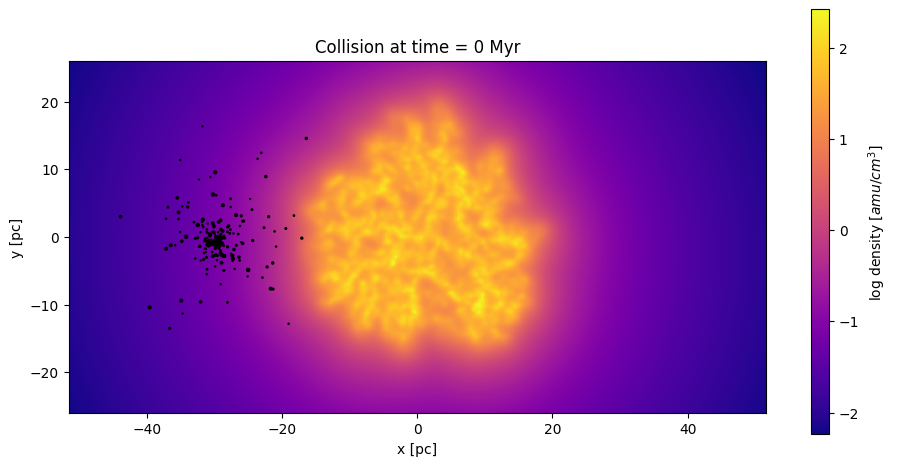

Pre stellar channels cluster mass 1.37092812332e+32 kg
Post stellar channels cluster mass 1.37092808721e+32 kg
Largest sink radius 0.219611656536 parsec
Post bridge cluster mass 1.37092808721e+32 kg
Sinks in progress at 0.1  Myr.
Post accretion cluster mass 1.37092808721e+32 kg
147271 number of cloud particles now 



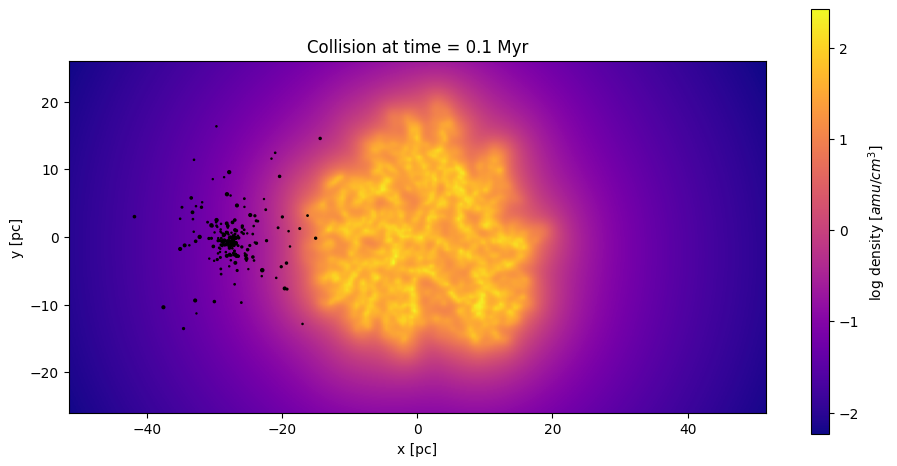

Pre stellar channels cluster mass 1.37092808721e+32 kg
Post stellar channels cluster mass 1.37092805107e+32 kg
Largest sink radius 0.219611656536 parsec
Post bridge cluster mass 1.37092805107e+32 kg
Sinks in progress at 0.2  Myr.
Post accretion cluster mass 1.37092805107e+32 kg
147271 number of cloud particles now 



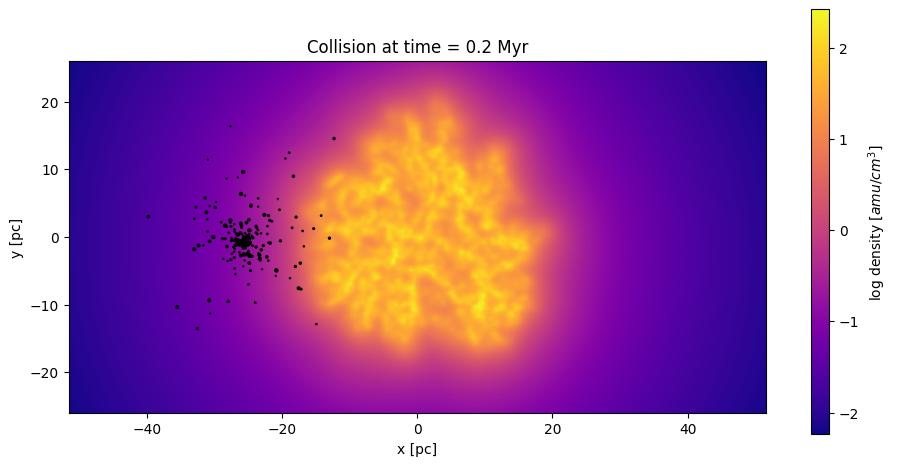

Pre stellar channels cluster mass 1.37092805107e+32 kg
Post stellar channels cluster mass 1.37092801489e+32 kg
Largest sink radius 0.219611656536 parsec
Post bridge cluster mass 1.37092801489e+32 kg
Sinks in progress at 0.3  Myr.
Post accretion cluster mass 1.37092801489e+32 kg
147271 number of cloud particles now 



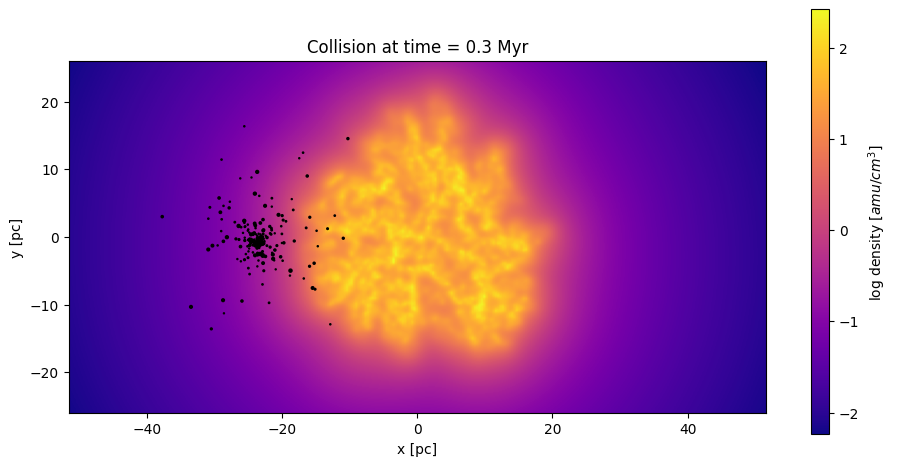

Pre stellar channels cluster mass 1.37092801489e+32 kg
Post stellar channels cluster mass 1.37092797867e+32 kg
Largest sink radius 0.219611656536 parsec
Post bridge cluster mass 1.37092797867e+32 kg
Sinks in progress at 0.4  Myr.
Post accretion cluster mass 1.37092797867e+32 kg
147271 number of cloud particles now 



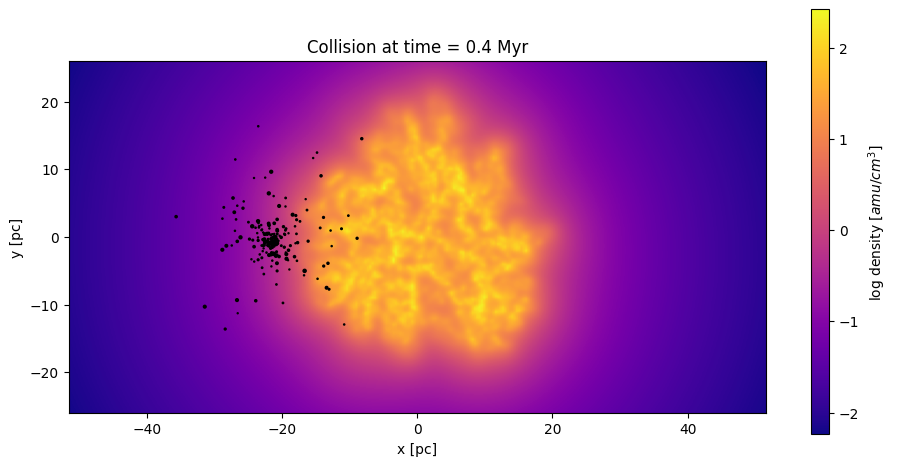

Pre stellar channels cluster mass 1.37092797867e+32 kg
Post stellar channels cluster mass 1.37092794241e+32 kg
Largest sink radius 0.219611656536 parsec
Post bridge cluster mass 1.37092794241e+32 kg
Sinks in progress at 0.5  Myr.
Post accretion cluster mass 1.37092794241e+32 kg
147271 number of cloud particles now 



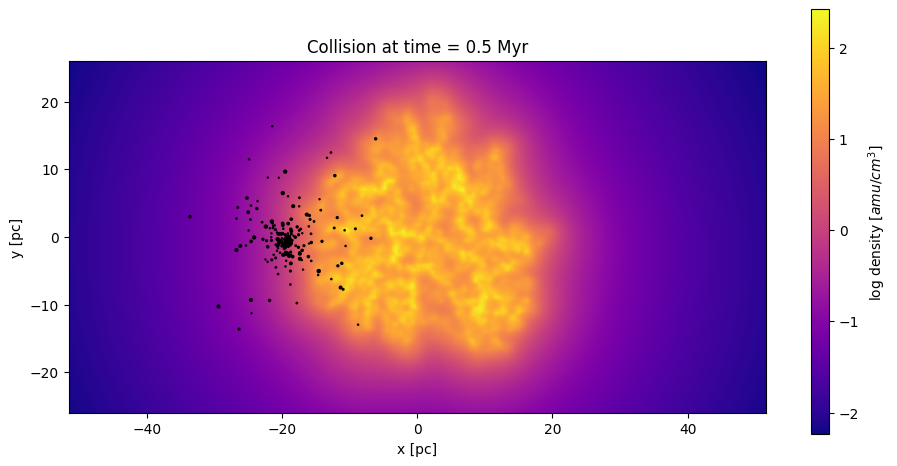

Pre stellar channels cluster mass 1.37092794241e+32 kg
Post stellar channels cluster mass 1.37092790612e+32 kg
Largest sink radius 0.219611656536 parsec
Post bridge cluster mass 1.37092790612e+32 kg
Sinks in progress at 0.6  Myr.
Post accretion cluster mass 1.37106727108e+32 kg
147271 number of cloud particles now 



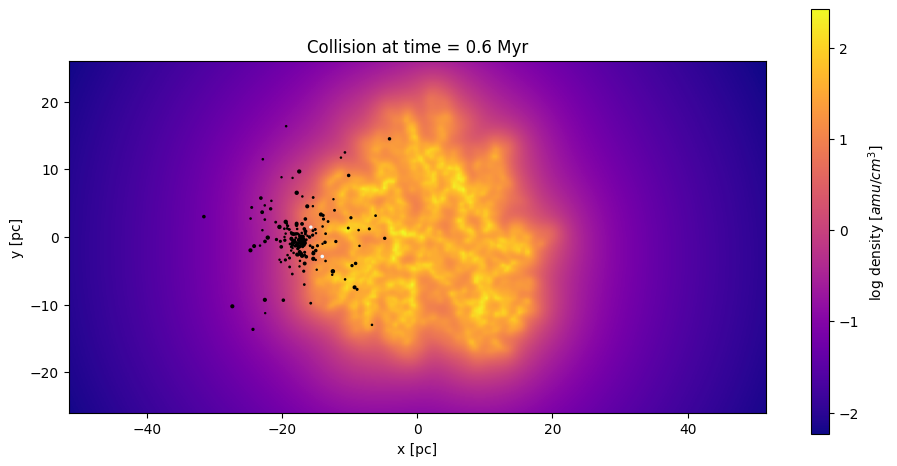

Pre stellar channels cluster mass 1.37106727108e+32 kg
Post stellar channels cluster mass 1.37106723474e+32 kg
Largest sink radius 0.219611656536 parsec
Post bridge cluster mass 1.37106723474e+32 kg
Sinks in progress at 0.7  Myr.
Post accretion cluster mass 1.37106723474e+32 kg
147271 number of cloud particles now 



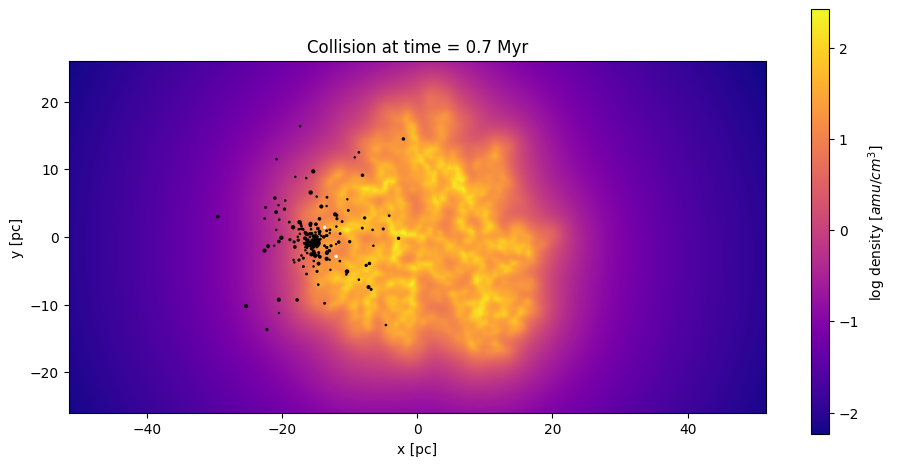

Pre stellar channels cluster mass 1.37106723474e+32 kg
Post stellar channels cluster mass 1.37106719837e+32 kg
Largest sink radius 0.219611656536 parsec
Post bridge cluster mass 1.37106719837e+32 kg
Sinks in progress at 0.8  Myr.
Post accretion cluster mass 1.37110956691e+32 kg
147271 number of cloud particles now 



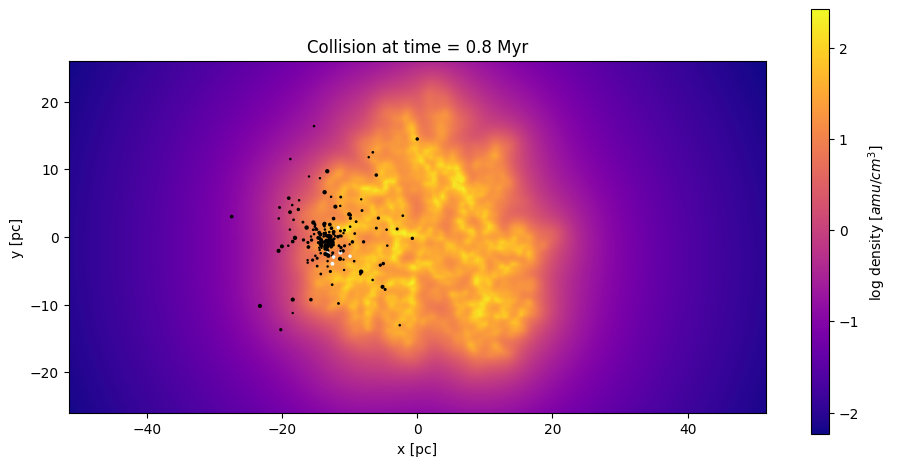

Pre stellar channels cluster mass 1.37110956691e+32 kg
Post stellar channels cluster mass 1.3711095305e+32 kg
Largest sink radius 0.219611656536 parsec
Post bridge cluster mass 1.3711095305e+32 kg
Sinks in progress at 0.9  Myr.
Post accretion cluster mass 1.37115617101e+32 kg
147271 number of cloud particles now 



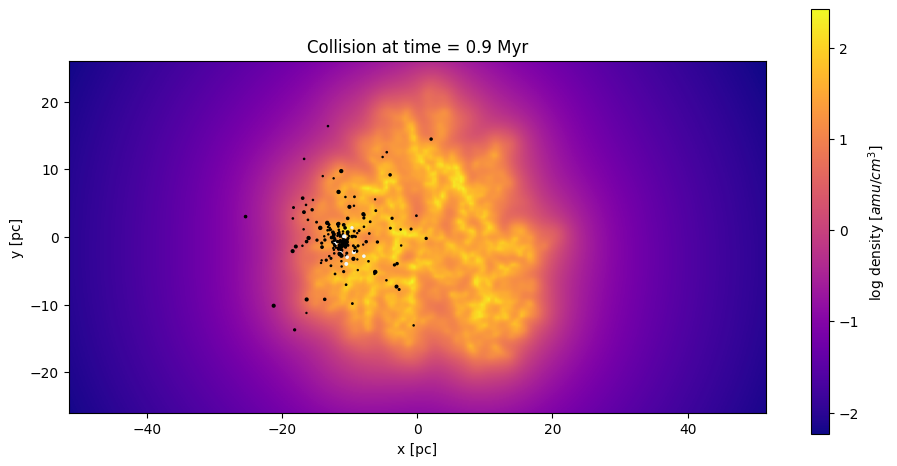

Pre stellar channels cluster mass 1.37115617101e+32 kg
Post stellar channels cluster mass 1.37115613455e+32 kg
Largest sink radius 0.219668452268 parsec
Post bridge cluster mass 1.37115613455e+32 kg
Sinks in progress at 1.0  Myr.
Post accretion cluster mass 1.37132281448e+32 kg
147271 number of cloud particles now 



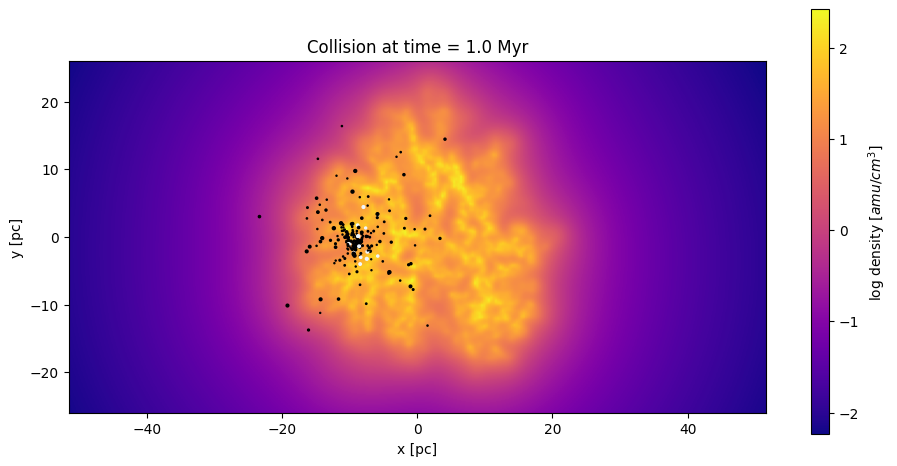

Pre stellar channels cluster mass 1.37132281448e+32 kg
Post stellar channels cluster mass 1.37132277799e+32 kg
Largest sink radius 0.219747109798 parsec
Post bridge cluster mass 1.37132277799e+32 kg
Sinks in progress at 1.1  Myr.
Post accretion cluster mass 1.37164819805e+32 kg
147271 number of cloud particles now 



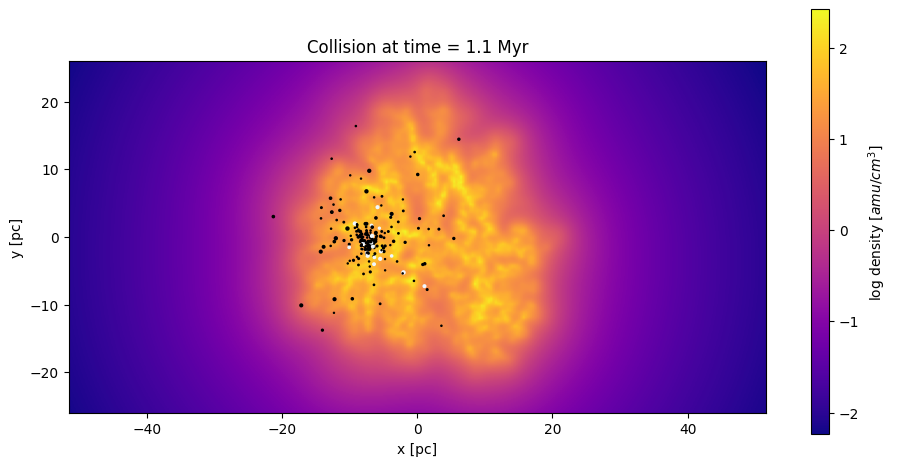

Pre stellar channels cluster mass 1.37164819805e+32 kg
Post stellar channels cluster mass 1.37164816152e+32 kg
Largest sink radius 0.21979435172 parsec
Post bridge cluster mass 1.37164816152e+32 kg
Sinks in progress at 1.2  Myr.
Post accretion cluster mass 1.37206803343e+32 kg
147271 number of cloud particles now 



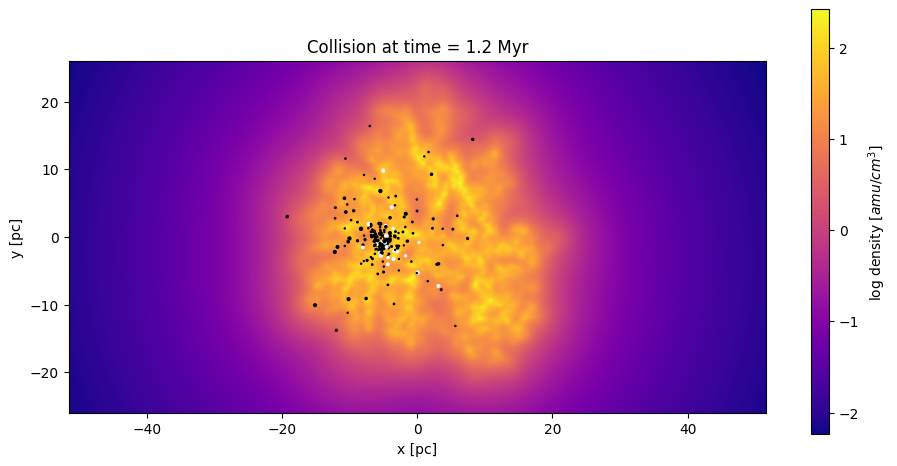

Pre stellar channels cluster mass 1.37206803343e+32 kg
Post stellar channels cluster mass 1.37206799686e+32 kg
Largest sink radius 0.21979435172 parsec
Post bridge cluster mass 1.37206799686e+32 kg
Sinks in progress at 1.3  Myr.
Post accretion cluster mass 1.37275261325e+32 kg
147271 number of cloud particles now 



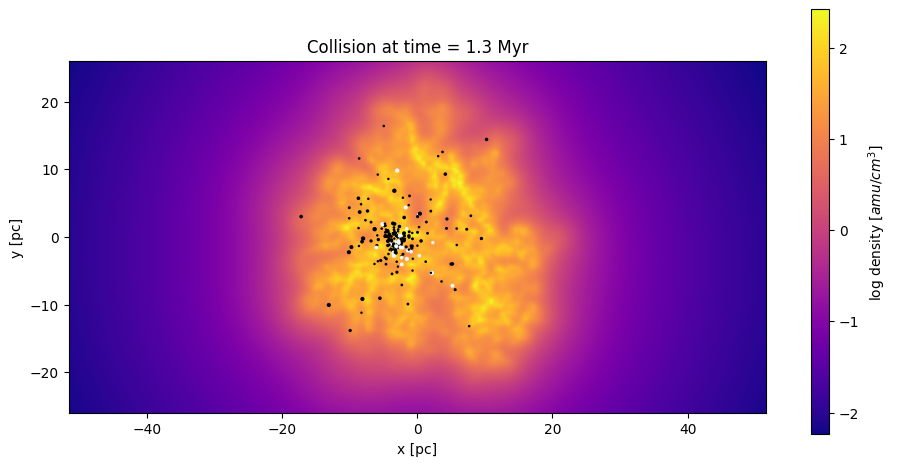

Pre stellar channels cluster mass 1.37275261325e+32 kg
Post stellar channels cluster mass 1.37275257664e+32 kg
Largest sink radius 0.220993393815 parsec
Post bridge cluster mass 1.37275257664e+32 kg
Sinks in progress at 1.4  Myr.
Post accretion cluster mass 1.37381063653e+32 kg
147271 number of cloud particles now 



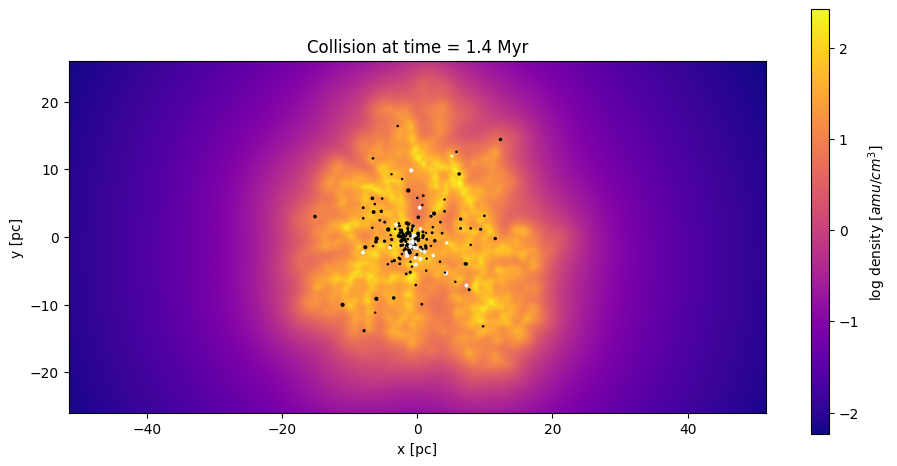

Pre stellar channels cluster mass 1.37381063653e+32 kg
Post stellar channels cluster mass 1.37381059988e+32 kg
Largest sink radius 0.221132283178 parsec
Post bridge cluster mass 1.37381059988e+32 kg
Sinks in progress at 1.5  Myr.
Post accretion cluster mass 1.37414140585e+32 kg
147271 number of cloud particles now 



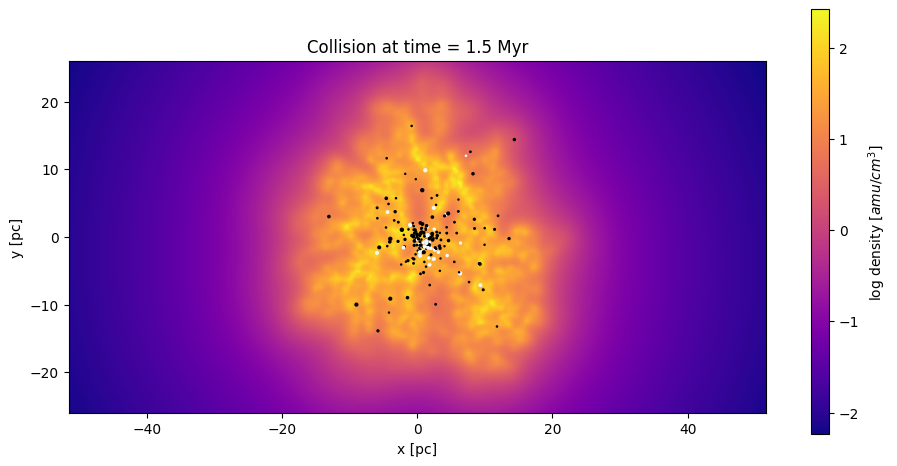

Pre stellar channels cluster mass 1.37414140585e+32 kg
Post stellar channels cluster mass 1.37414136916e+32 kg
Largest sink radius 0.221132283178 parsec
Post bridge cluster mass 1.37414136916e+32 kg
Sinks in progress at 1.6  Myr.
Post accretion cluster mass 1.37437511381e+32 kg
147271 number of cloud particles now 



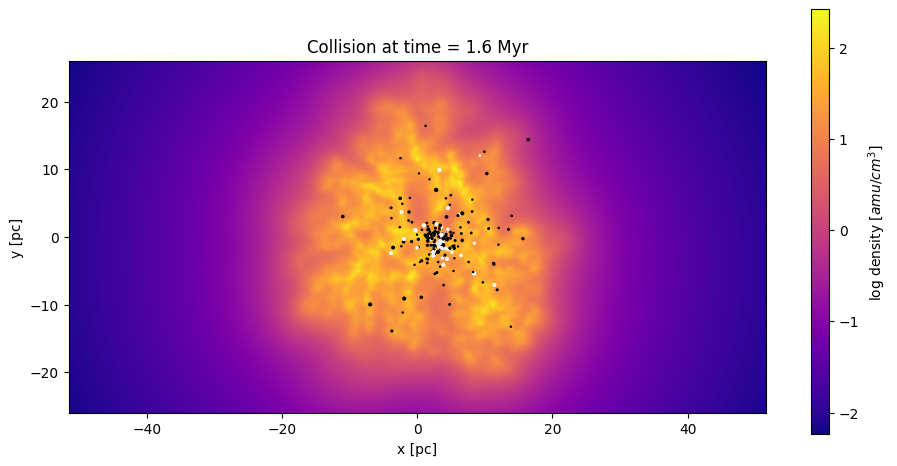

Pre stellar channels cluster mass 1.37437511381e+32 kg
Post stellar channels cluster mass 1.37437507708e+32 kg
Largest sink radius 0.221132283178 parsec
Post bridge cluster mass 1.37437507708e+32 kg
Sinks in progress at 1.7  Myr.
Post accretion cluster mass 1.37468506554e+32 kg
147271 number of cloud particles now 



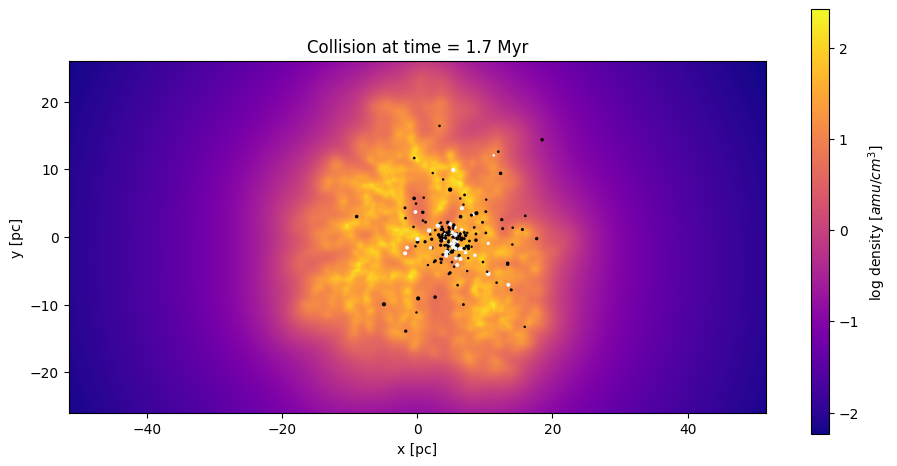

Pre stellar channels cluster mass 1.37468506554e+32 kg
Post stellar channels cluster mass 1.37468502877e+32 kg
Largest sink radius 0.221132283178 parsec
Post bridge cluster mass 1.37468502877e+32 kg
Sinks in progress at 1.8  Myr.
Post accretion cluster mass 1.37490817546e+32 kg
147271 number of cloud particles now 



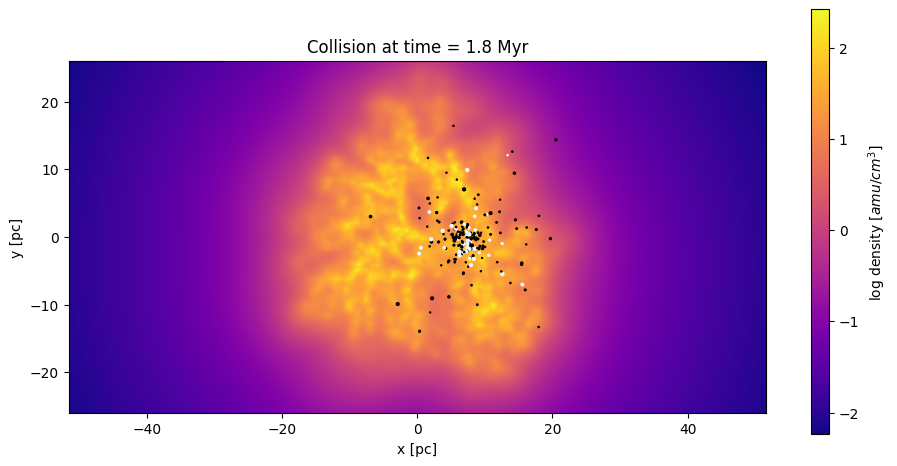

Pre stellar channels cluster mass 1.37490817546e+32 kg
Post stellar channels cluster mass 1.37490813866e+32 kg
Largest sink radius 0.221132283178 parsec
Post bridge cluster mass 1.37490813866e+32 kg
Sinks in progress at 1.9  Myr.
Post accretion cluster mass 1.37505267168e+32 kg
147271 number of cloud particles now 



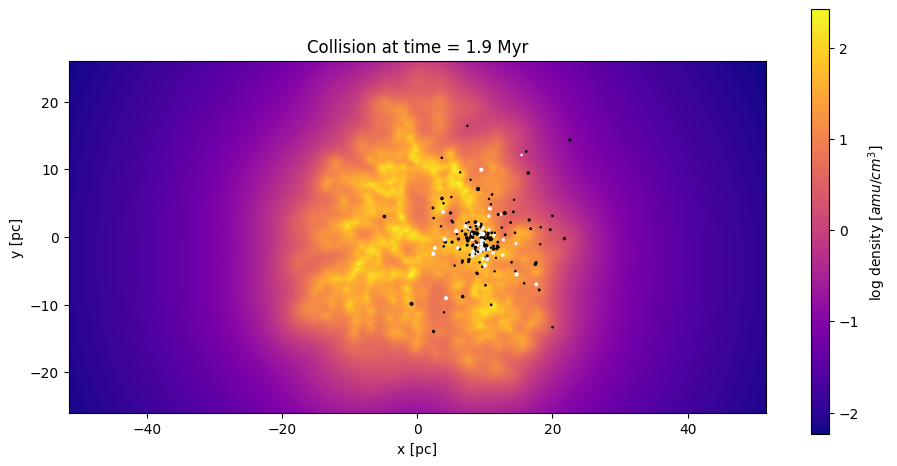

Pre stellar channels cluster mass 1.37505267168e+32 kg
Post stellar channels cluster mass 1.37505263484e+32 kg
Largest sink radius 0.221295866389 parsec
Post bridge cluster mass 1.37505263484e+32 kg
Sinks in progress at 2.0  Myr.
Post accretion cluster mass 1.37528882998e+32 kg
147271 number of cloud particles now 



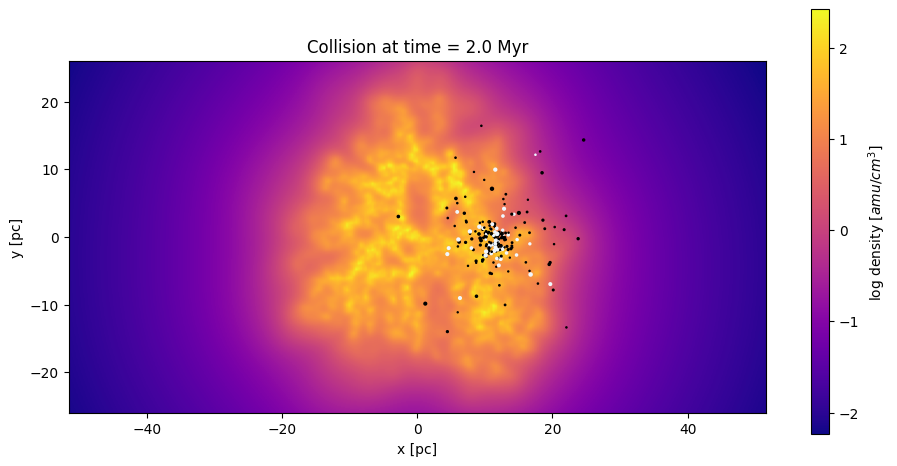

In [31]:
t_end = 2 | units.Myr
model_time = 0 | units.Myr
dt = 0.1 | units.Myr

x_lim = int(abs(min(sinks.position.x).value_in(units.pc)))*1.2
y_lim = int(abs(min(sinks.position.y).value_in(units.pc)))*2
N = 300

path = "../results/test/SE/"
os.makedirs(path, exist_ok=True)


plot_cloud_and_star_cluster(model_time, hydro_cloud, sinks, x_lim, y_lim, N, density_map, f"../results/test/SE/collision_at_{model_time.value_in(units.Myr)}.png")
# plot_snapshot_and_HR(star_cluster)

sinks_mass_snapshots = []

while model_time < t_end:
    
    # define the accreting radius of the sinks particle based on its Bondi radius
    # IMPORTANT: the mass changes after each accretion event

    print("Pre stellar channels cluster mass", sinks.mass.sum())
    
    model_time += dt
    model_time = model_time.round(1)

    stellar_evolution_code.evolve_model(model_time)

    channel["stellar_evolution_to_sinks"].copy()
    channel["gravity_from_sinks"].copy()

    print("Post stellar channels cluster mass", sinks.mass.sum())
    
    sinks.sink_radius = [bondi_radius(sink.mass).in_(units.pc) for sink in sinks]

    print("Largest sink radius", max(sinks.sink_radius).in_(units.pc))

    # evolve the gravity and hydro codes through our bridge
    gravhydrostellarbridge.evolve_model(model_time)

    # update channels (copy over from the codes.particles to the particle sets)
    channel["gravity_to_sinks"].copy()
    channel["hydro_to_cloud"].copy()

    print("Post bridge cluster mass", sinks.mass.sum())

    print("Sinks in progress at", model_time.value_in(units.Myr), " Myr.")
    # add the acretted mass to the sinks's total mass
    accrete_mass(sinks, particles_cloud, dt)

    # update channels (copy the information from the particle set to the gravity code)
    channel["stellar_evolution_from_sinks"].copy()
    channel["gravity_from_sinks"].copy()
    channel["hydro_from_cloud"].copy()

    # save the total mass of each step
    sinks_mass_snapshots.append(sinks.mass.value_in(units.MSun))

    print("Post accretion cluster mass", sinks.mass.sum())
    print(len(particles_cloud.mass), "number of cloud particles now \n")

    plot_cloud_and_star_cluster(model_time, hydro_cloud, sinks, x_lim, y_lim, N, density_map, f"../results/test/SE/collision_at_{model_time.value_in(units.Myr)}.png")
    # plot_snapshot_and_HR(star_cluster)
    

In [32]:
mass_difference = sinks_mass_snapshots[-1] - sinks_mass_snapshots[0]
mask = np.where(abs(mass_difference) > 1e-15)
print(len(mask[0]))
print(mass_difference)

51
[  2.65143945e-03   3.13334055e-03   8.32667268e-17   0.00000000e+00
   5.55111512e-17   4.99099531e-04   0.00000000e+00   0.00000000e+00
   0.00000000e+00   4.43723819e-03   0.00000000e+00   6.66133815e-16
   2.77555756e-17   0.00000000e+00   3.61506879e-03   0.00000000e+00
   1.17530347e-03   2.37233501e-03   0.00000000e+00   1.95836421e-03
   5.55111512e-17   0.00000000e+00   0.00000000e+00   1.66533454e-16
   0.00000000e+00   4.83429366e-03   0.00000000e+00   0.00000000e+00
   1.94289029e-16   5.55111512e-17   5.94827053e-03   0.00000000e+00
   0.00000000e+00   0.00000000e+00   8.32667268e-17   9.71445147e-17
   0.00000000e+00   1.14640479e-03   1.12573695e-02   4.16333634e-17
   9.69161850e-03   2.77555756e-17   5.85672896e-04   0.00000000e+00
   1.11022302e-16   2.22044605e-16   1.38777878e-17   9.70009581e-04
   4.16333634e-17   1.66533454e-16   5.55111512e-17   0.00000000e+00
   0.00000000e+00   1.38777878e-17   0.00000000e+00   7.82987822e-03
   0.00000000e+00   8.32667268e

In [33]:
np.array(sinks_mass_snapshots)[:, mask[0]]

array([[ 0.35870842,  0.52198416,  0.78576639, ...,  0.69538625,
         0.64532823,  0.76662199],
       [ 0.35870842,  0.52198416,  0.78576639, ...,  0.69538625,
         0.64532823,  0.76662199],
       [ 0.35870842,  0.52198416,  0.78576639, ...,  0.69538625,
         0.64532823,  0.76662199],
       ..., 
       [ 0.36135986,  0.5251175 ,  0.78576639, ...,  0.6967149 ,
         0.64957663,  0.77057776],
       [ 0.36135986,  0.5251175 ,  0.78626549, ...,  0.6967149 ,
         0.64957663,  0.77150136],
       [ 0.36135986,  0.5251175 ,  0.78626549, ...,  0.6967149 ,
         0.64957663,  0.77150136]])

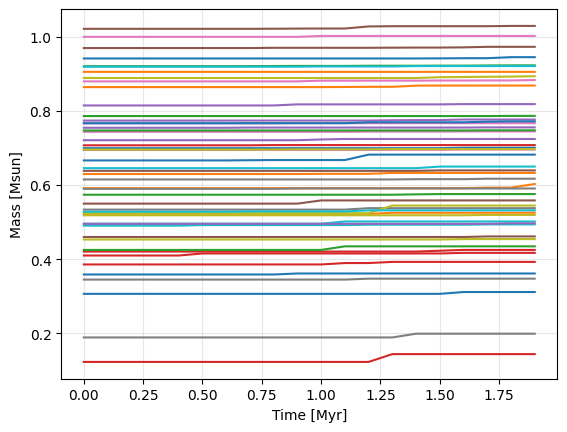

In [35]:
plt.plot(np.arange(0, 2.0, 0.1), np.array(sinks_mass_snapshots)[:, mask[0]])
plt.grid(alpha = 0.3)
plt.xlabel("Time [Myr]")
plt.ylabel("Mass [Msun]")
plt.show()
# add vertical lines for when the cluster enters and leaves the cloud 

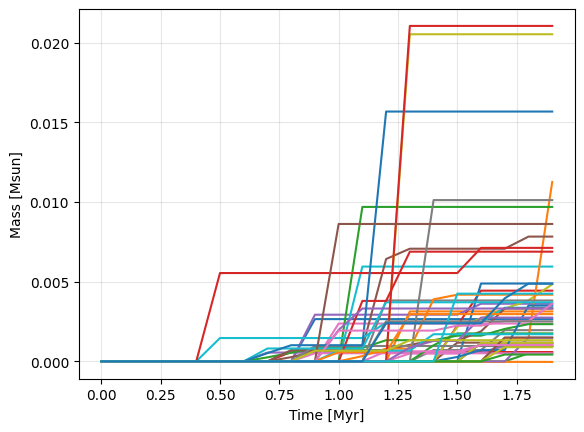

In [38]:
data = np.array(sinks_mass_snapshots)[:, mask[0]]
plt.plot(np.arange(0, 2.0, 0.1), data-data[0,:])
plt.grid(alpha = 0.3)
plt.xlabel("Time [Myr]")
plt.ylabel("Mass [Msun]")
plt.show()
# add vertical lines for when the cluster enters and leaves the cloud 

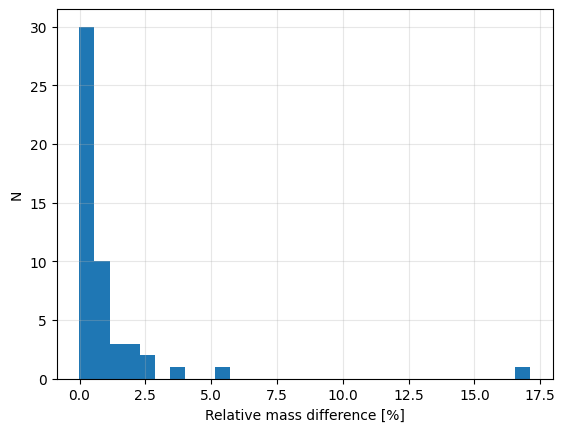

In [36]:
relative_mass = np.array(mass_difference)[mask[0]]/np.array(sinks_mass_snapshots[0])[mask[0]]
plt.hist(relative_mass*100, bins  = 30)
plt.grid(alpha = 0.3)
plt.xlabel("Relative mass difference [%]")
plt.ylabel("N")
plt.show()

In [37]:
gravity_code.stop()
hydro_cloud.stop()
stellar_evolution_code.stop()
gravhydrostellarbridge.stop()